<a href="https://colab.research.google.com/github/leandro-driguez/Machine-Learning-Techniques/blob/dev/Lab_1/Sesi%C3%B3n%201/RidgeRegularization.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" />
</a>

In [1]:
import gc
import warnings
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## Dataset

In [2]:
url = 'https://raw.githubusercontent.com/leandro-driguez/Machine-Learning-Techniques/main/Lab_1/Sesi%C3%B3n%201/kc_house_data.csv'
data = pd.read_csv(url)
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
# remove unnecesary columns and split X & y
X = data.drop(['id','date','zipcode','sqft_above','price'],axis=1)
y = data['price']

In [4]:
# normalize data
columns = X.columns
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
X = pd.DataFrame(X,columns=columns)

In [5]:
def generate_polynomial_features(df: pd.DataFrame, degree: int):
    """
    Generate a DataFrame with polynomial features of specified degree from the input DataFrame.

    This includes all combinations of features raised to powers that sum up to the degree.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with the original features.
    - degree (int): Degree of the polynomial features to generate.

    Returns:
    - pd.DataFrame: DataFrame containing the original features along with their polynomial
                    and interaction combinations up to the specified degree.
    """
    # Validate inputs
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame.")
    if not isinstance(degree, int) or degree < 1:
        raise ValueError("Degree must be a positive integer.")

    # List to hold all polynomial features
    poly_features = [df.copy()]

    # Iterate over degrees to generate polynomial combinations
    for d in range(2, degree + 1):
        for items in itertools.combinations_with_replacement(df.columns, d):
            # Generate the feature name for the combination
            feature_name = "*".join(items)

            # Reduce to calculate the product (i.e., (x1*x2), (x1*x2*x3), ...)
            feature = pd.DataFrame(df.loc[:, items].prod(axis=1), columns=[feature_name])

            # Append the new feature
            poly_features.append(feature)

    # Concatenate all polynomial features
    poly_features_df = pd.concat(poly_features, axis=1)

    return poly_features_df

## Hyperparameter setting

In [6]:
Models, MAE, MSE, R2_score = [], [], [], []
MAX_DEGREE = 4

In [7]:
# split the dataset in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

Utilizing cross-validation, regularization parameter selection, and memory management is crucial for optimizing model performance, preventing overfitting, and ensuring efficient computation.

In [8]:
def select_best_alpha(model_cv, X, y, alphas):
    """Find the best alpha using cross-validation."""
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', ConvergenceWarning)
        model = model_cv(alphas=alphas, cv=5).fit(X, y)
    return model.alpha_

In [9]:
alphas = np.logspace(-6, 3, 20)
best_alpha_ridge = select_best_alpha(RidgeCV, X_train, y_train, alphas)
print(f"The best alpha for the Lasso model is {best_alpha_ridge}")

The best alpha for the Lasso model is 0.1623776739188721


In [10]:
for k_degree in range(1, MAX_DEGREE+1):
    # Prepare dataset
    X_train_pol = generate_polynomial_features(X_train, degree=k_degree)
    X_test_pol = generate_polynomial_features(X_test, degree=k_degree)

    # Training
    LinearModel = Ridge(alpha=best_alpha_ridge).fit(X_train_pol, y_train)

    # Prediction
    y_pred = LinearModel.predict(X_test_pol)

    # Validation
    MAE.append(np.mean(np.absolute(y_pred - y_test)))
    MSE.append(mean_squared_error(y_pred , y_test))
    R2_score.append(r2_score(y_pred , y_test))

    # Clean memory
    del X_train_pol, X_test_pol, y_pred
    gc.collect()

## Visualization

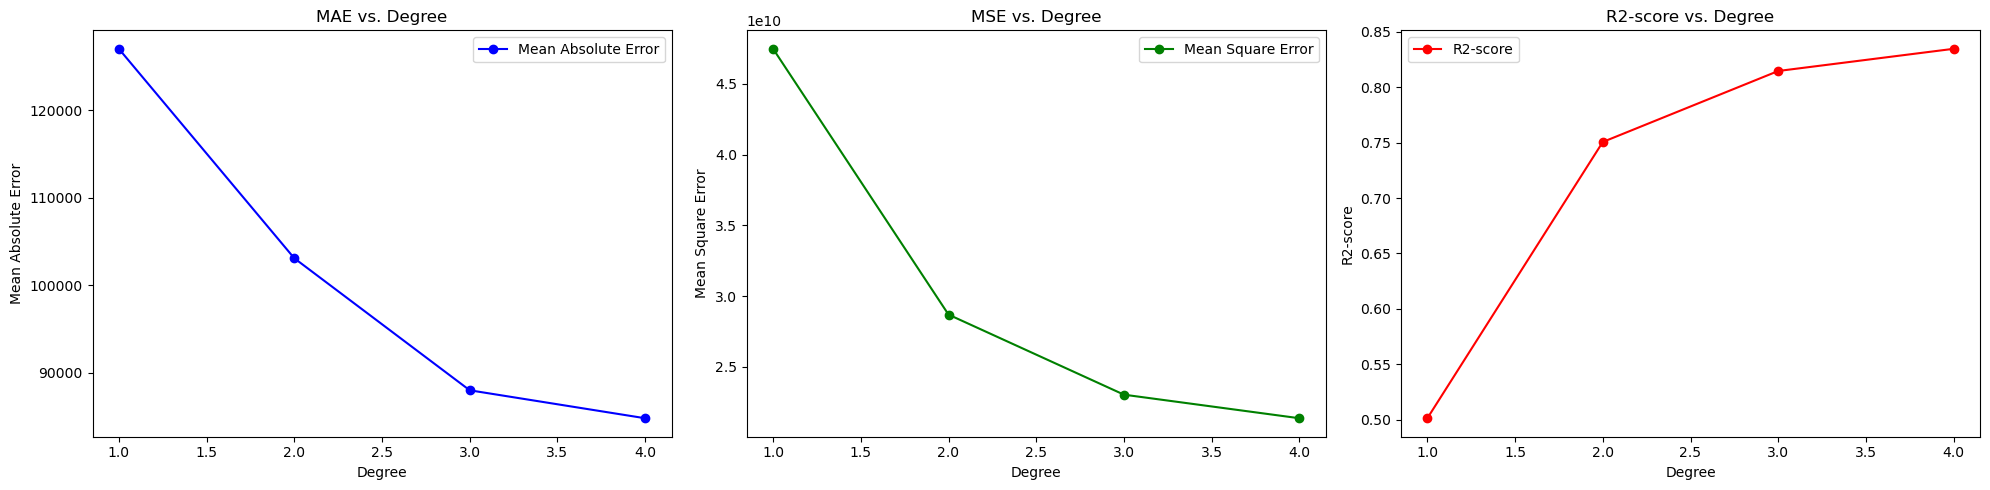

In [11]:
degrees = [dg for dg in range(1, MAX_DEGREE+1)]

# Plotting each metric in a separate subplot
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

# Mean Absolute Error Plot
axs[0].plot(degrees, MAE, 'bo-', label='Mean Absolute Error')
axs[0].set(title='MAE vs. Degree', xlabel='Degree', ylabel='Mean Absolute Error')
axs[0].legend()

# Mean Square Error Plot
axs[1].plot(degrees, MSE, 'go-', label='Mean Square Error')
axs[1].set(title='MSE vs. Degree', xlabel='Degree', ylabel='Mean Square Error')
axs[1].legend()

# R2-score Plot
axs[2].plot(degrees, R2_score, 'ro-', label='R2-score')
axs[2].set(title='R2-score vs. Degree', xlabel='Degree', ylabel='R2-score')
axs[2].legend()

plt.tight_layout()
plt.show()